# Load trade and production data (1993-2023)

In [1]:
import pandas as pd
import os
import numpy as np

trade_directory = "trade_data"

trades = []
for file in os.listdir(trade_directory):
    if file.endswith(".csv"): 
        trades.append(pd.read_csv(os.path.join(trade_directory, file),sep=",",index_col=False,encoding = 'ISO-8859-1'))


trade = pd.concat(trades,ignore_index=True, axis=0)
trade = trade[["refYear","reporterDesc","partnerDesc","flowDesc","qty","isAggregate"]].fillna(0.)

# fill gaps with ARIMA

In [4]:
def need2be_imputed(tmp,target="qty"):
    if len(tmp) > 0:
        right_empty = 0
        zeros = 0
        flag = True
        for i,row in tmp.reindex().sort_index(ascending=False).iterrows():
            if  math.isnan(row[target]):
                zeros += 1
                if flag:
                    right_empty += 1    
            else:
                flag = False
        if right_empty < 3 and zeros > 0:
            return True, 0
        else:    
            if zeros > 0 and right_empty == zeros:
                return False, right_empty
            else:
                if zeros == 0:
                    return False, 0
                else:    
                    return True, right_empty
    else:    
        return False, 0

In [2]:
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings
import math
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.seterr(divide = 'ignore') 

reporters = np.unique(trade['reporterDesc'])

print("Original trade size:", len(trade))

# drop duplicate lines
print("Drop duplicates")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            years = np.unique(trade["refYear"].to_numpy())
            for year in years:
                year_trade = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]
                if len(year_trade) > 1:
                    remain = year_trade['qty'].idxmax()
                    #print(r,partner,len(year_trade))
                    for id_,_ in year_trade.iterrows():
                        if id_ != remain:
                            trade = trade.drop(id_)
                   #print("Control:",r,partner, len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]))        
print("Trade size after de-duplication:",len(trade))
print("Impute nans")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            years = np.unique(trade["refYear"].to_numpy())
            for year in years:
                if len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]) == 0:
                     row =  pd.DataFrame({"refYear":year,	"reporterDesc":r,	"partnerDesc":partner,	"flowDesc":flow,"qty":math.nan,	"isAggregate":False},index=[0])
                     trade = pd.concat([trade.loc[:],row],axis=0).reset_index(drop=True)

            tmp = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['partnerDesc']==partner)]
            flag,zero_len = need2be_imputed(tmp)
            if flag:
                X = tmp.sort_values(by='refYear')
                #TODO - set index
                #nulls = np.isnan(X['qty'].to_numpy())
                transformer = Imputer(method="forecaster", forecaster=AutoARIMA(suppress_warnings=True))
                X_ = transformer.fit_transform(X['qty'].to_numpy().flatten()[:len(X) - zero_len])
                #print(X)
                #print(X_)
                #print(X['qty'].to_numpy().flatten(), "-->", X_.flatten())
                for i,v in enumerate(X.iterrows()):
                    idx, row = v
                    if i < len(X_):
                        if X_[i] > 0.:
                            trade.loc[idx,"qty"] = X_[i]
                            print(idx,row,"->",X_[i])
                        

trade = trade.fillna(0.)

print("Final trade size:",len(trade))

trade.to_csv("trade.csv",sep=";")


Original trade size: 117877
Drop duplicates


100%|███████████████████████████████████████| 211/211 [2:30:26<00:00, 42.78s/it]


Trade size after de-duplication: 91437
Impute nans


  3%|█▎                                       | 7/211 [03:08<1:11:39, 21.07s/it]

40689 refYear                                     1993
reporterDesc                           Argentina
partnerDesc     Bolivia (Plurinational State of)
flowDesc                                  Export
qty                                   63038064.0
isAggregate                                False
Name: 40689, dtype: object -> [63038064.]
21583 refYear                                     1994
reporterDesc                           Argentina
partnerDesc     Bolivia (Plurinational State of)
flowDesc                                  Export
qty                                   67901872.0
isAggregate                                False
Name: 21583, dtype: object -> [67901872.]
29050 refYear                                     1995
reporterDesc                           Argentina
partnerDesc     Bolivia (Plurinational State of)
flowDesc                                  Export
qty                                    4760750.0
isAggregate                                False
Name: 29050, dty

  5%|██                                      | 11/211 [09:11<4:12:17, 75.69s/it]

118960 refYear            1993
reporterDesc    Austria
partnerDesc     Croatia
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 118960, dtype: object -> [20727574.]
21614 refYear               1994
reporterDesc       Austria
partnerDesc        Croatia
flowDesc            Export
qty             20727574.0
isAggregate          False
Name: 21614, dtype: object -> [20727574.]
118961 refYear            1995
reporterDesc    Austria
partnerDesc     Croatia
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 118961, dtype: object -> [20727574.]
61959 refYear              1996
reporterDesc      Austria
partnerDesc       Croatia
flowDesc           Export
qty             1036125.0
isAggregate         False
Name: 61959, dtype: object -> [1036125.]
10276 refYear              1997
reporterDesc      Austria
partnerDesc       Croatia
flowDesc           Export
qty             1429312.0
isAggregate         False
Name: 10276, dtype: object -> [142931

 11%|████▌                                   | 24/211 [20:53<1:37:56, 31.43s/it]

41246 refYear                                     1993
reporterDesc    Bolivia (Plurinational State of)
partnerDesc                                  USA
flowDesc                                  Import
qty                                  133310816.0
isAggregate                                False
Name: 41246, dtype: object -> [1.33310816e+08]
21624 refYear                                     1994
reporterDesc    Bolivia (Plurinational State of)
partnerDesc                                  USA
flowDesc                                  Import
qty                                   72174392.0
isAggregate                                False
Name: 21624, dtype: object -> [72174392.]
29185 refYear                                     1995
reporterDesc    Bolivia (Plurinational State of)
partnerDesc                                  USA
flowDesc                                  Import
qty                                  102305448.0
isAggregate                                False
Name: 29185

 13%|█████                                   | 27/211 [23:23<2:13:37, 43.57s/it]

153885 refYear             1993
reporterDesc      Brazil
partnerDesc     Paraguay
flowDesc          Import
qty                  NaN
isAggregate        False
Name: 153885, dtype: object -> [21080000.]
21637 refYear               1994
reporterDesc        Brazil
partnerDesc       Paraguay
flowDesc            Import
qty             21080000.0
isAggregate          False
Name: 21637, dtype: object -> [21080000.]
29194 refYear              1995
reporterDesc       Brazil
partnerDesc      Paraguay
flowDesc           Import
qty             8009988.0
isAggregate         False
Name: 29194, dtype: object -> [8009988.]
62030 refYear               1996
reporterDesc        Brazil
partnerDesc       Paraguay
flowDesc            Import
qty             55472500.0
isAggregate          False
Name: 62030, dtype: object -> [55472500.]
11346 refYear                1997
reporterDesc         Brazil
partnerDesc        Paraguay
flowDesc             Import
qty             246505936.0
isAggregate           False
Nam

 14%|█████▋                                  | 30/211 [29:29<4:51:14, 96.54s/it]

162777 refYear                 1993
reporterDesc    Burkina Faso
partnerDesc           France
flowDesc              Import
qty                      NaN
isAggregate            False
Name: 162777, dtype: object -> [26641204.17507205]
162778 refYear                 1994
reporterDesc    Burkina Faso
partnerDesc           France
flowDesc              Import
qty                      NaN
isAggregate            False
Name: 162778, dtype: object -> [26641204.17507205]
30756 refYear                 1995
reporterDesc    Burkina Faso
partnerDesc           France
flowDesc              Import
qty               28607636.0
isAggregate            False
Name: 30756, dtype: object -> [28607636.]
63623 refYear                 1996
reporterDesc    Burkina Faso
partnerDesc           France
flowDesc              Import
qty               32062372.0
isAggregate            False
Name: 63623, dtype: object -> [32062372.]
10425 refYear                 1997
reporterDesc    Burkina Faso
partnerDesc           France

 17%|██████▋                                 | 35/211 [34:06<3:04:56, 63.05s/it]

40666 refYear               1993
reporterDesc        Canada
partnerDesc     Bangladesh
flowDesc            Export
qty             25041000.0
isAggregate          False
Name: 40666, dtype: object -> [25041000.]
21689 refYear                1994
reporterDesc         Canada
partnerDesc      Bangladesh
flowDesc             Export
qty             213536000.0
isAggregate           False
Name: 21689, dtype: object -> [2.13536e+08]
29213 refYear                1995
reporterDesc         Canada
partnerDesc      Bangladesh
flowDesc             Export
qty             163209000.0
isAggregate           False
Name: 29213, dtype: object -> [1.63209e+08]
171848 refYear               1996
reporterDesc        Canada
partnerDesc     Bangladesh
flowDesc            Export
qty                    NaN
isAggregate          False
Name: 171848, dtype: object -> [1.63209e+08]
10093 refYear                1997
reporterDesc         Canada
partnerDesc      Bangladesh
flowDesc             Export
qty             235895

 19%|███████▌                                | 40/211 [41:06<2:54:08, 61.10s/it]

40721 refYear                 1993
reporterDesc           China
partnerDesc           Canada
flowDesc              Import
qty             3058574000.0
isAggregate            False
Name: 40721, dtype: object -> [3.058574e+09]
21758 refYear                 1994
reporterDesc           China
partnerDesc           Canada
flowDesc              Import
qty             3585990276.0
isAggregate            False
Name: 21758, dtype: object -> [3.58599028e+09]
29307 refYear                 1995
reporterDesc           China
partnerDesc           Canada
flowDesc              Import
qty             4861572109.0
isAggregate            False
Name: 29307, dtype: object -> [4.86157211e+09]
62143 refYear                 1996
reporterDesc           China
partnerDesc           Canada
flowDesc              Import
qty             3614839925.0
isAggregate            False
Name: 62143, dtype: object -> [3.61483992e+09]
10188 refYear                 1997
reporterDesc           China
partnerDesc           Canada
f

 22%|████████▉                               | 47/211 [46:48<1:42:32, 37.51s/it]

193601 refYear               1993
reporterDesc    Costa Rica
partnerDesc            USA
flowDesc            Import
qty                    NaN
isAggregate          False
Name: 193601, dtype: object -> [1.52451312e+08]
21781 refYear                1994
reporterDesc     Costa Rica
partnerDesc             USA
flowDesc             Import
qty             152451312.0
isAggregate           False
Name: 21781, dtype: object -> [1.52451312e+08]
29327 refYear                1995
reporterDesc     Costa Rica
partnerDesc             USA
flowDesc             Import
qty             146871472.0
isAggregate           False
Name: 29327, dtype: object -> [1.46871472e+08]
62154 refYear                1996
reporterDesc     Costa Rica
partnerDesc             USA
flowDesc             Import
qty             842486656.0
isAggregate           False
Name: 62154, dtype: object -> [8.42486656e+08]
11540 refYear                1997
reporterDesc     Costa Rica
partnerDesc             USA
flowDesc             Import
qt

 23%|█████████                               | 48/211 [47:38<1:51:59, 41.22s/it]

194034 refYear            1993
reporterDesc    Croatia
partnerDesc     Austria
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 194034, dtype: object -> [3182912.08258125]
21795 refYear             1994
reporterDesc     Croatia
partnerDesc      Austria
flowDesc          Import
qty             100000.0
isAggregate        False
Name: 21795, dtype: object -> [100000.]
194035 refYear            1995
reporterDesc    Croatia
partnerDesc     Austria
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 194035, dtype: object -> [1498369.77722132]
62162 refYear              1996
reporterDesc      Croatia
partnerDesc       Austria
flowDesc           Import
qty             1003000.0
isAggregate         False
Name: 62162, dtype: object -> [1003000.]
10067 refYear              1997
reporterDesc      Croatia
partnerDesc       Austria
flowDesc           Import
qty             1114000.0
isAggregate         False
Name: 10067, dtype: object -> [111400

 25%|█████████▊                              | 52/211 [51:48<2:16:55, 51.67s/it]

40659 refYear             1993
reporterDesc     Czechia
partnerDesc      Austria
flowDesc          Export
qty             163378.0
isAggregate        False
Name: 40659, dtype: object -> [163378.]
21815 refYear             1994
reporterDesc     Czechia
partnerDesc      Austria
flowDesc          Export
qty             109500.0
isAggregate        False
Name: 21815, dtype: object -> [109500.]
29366 refYear              1995
reporterDesc      Czechia
partnerDesc       Austria
flowDesc           Export
qty             1811292.0
isAggregate         False
Name: 29366, dtype: object -> [1811292.]
62191 refYear             1996
reporterDesc     Czechia
partnerDesc      Austria
flowDesc          Export
qty             271000.0
isAggregate        False
Name: 62191, dtype: object -> [271000.]
200616 refYear            1997
reporterDesc    Czechia
partnerDesc     Austria
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 200616, dtype: object -> [21044523.35041398]
64130 r

 25%|██████████                              | 53/211 [54:04<3:22:49, 77.02s/it]

40527 refYear                1993
reporterDesc        Czechia
partnerDesc           World
flowDesc             Export
qty             126786928.0
isAggregate           False
Name: 40527, dtype: object -> [1.26786928e+08]
21803 refYear               1994
reporterDesc       Czechia
partnerDesc          World
flowDesc            Export
qty             28722268.0
isAggregate          False
Name: 21803, dtype: object -> [28722268.]
29385 refYear                 1995
reporterDesc         Czechia
partnerDesc            World
flowDesc              Export
qty             1018273984.0
isAggregate            False
Name: 29385, dtype: object -> [1.01827398e+09]
62196 refYear                1996
reporterDesc        Czechia
partnerDesc           World
flowDesc             Export
qty             145320128.0
isAggregate           False
Name: 62196, dtype: object -> [1.45320128e+08]
203437 refYear            1997
reporterDesc    Czechia
partnerDesc       World
flowDesc         Export
qty               

 26%|██████████▍                             | 55/211 [56:23<3:09:25, 72.85s/it]

40819 refYear                1993
reporterDesc        Denmark
partnerDesc          France
flowDesc             Export
qty             125291624.0
isAggregate           False
Name: 40819, dtype: object -> [1.25291624e+08]
21854 refYear               1994
reporterDesc       Denmark
partnerDesc         France
flowDesc            Export
qty             45938536.0
isAggregate          False
Name: 21854, dtype: object -> [45938536.]
29404 refYear               1995
reporterDesc       Denmark
partnerDesc         France
flowDesc            Export
qty             79012624.0
isAggregate          False
Name: 29404, dtype: object -> [79012624.]
62204 refYear               1996
reporterDesc       Denmark
partnerDesc         France
flowDesc            Export
qty             18505050.0
isAggregate          False
Name: 62204, dtype: object -> [18505050.]
208573 refYear            1997
reporterDesc    Denmark
partnerDesc      France
flowDesc         Export
qty                 NaN
isAggregate       Fals

 27%|██████████▎                            | 56/211 [59:32<4:37:27, 107.40s/it]

40526 refYear                 1993
reporterDesc         Denmark
partnerDesc            World
flowDesc              Export
qty             1332166784.0
isAggregate            False
Name: 40526, dtype: object -> [1.33216678e+09]
21841 refYear                1994
reporterDesc        Denmark
partnerDesc           World
flowDesc             Export
qty             794429248.0
isAggregate           False
Name: 21841, dtype: object -> [7.94429248e+08]
29423 refYear                 1995
reporterDesc         Denmark
partnerDesc            World
flowDesc              Export
qty             1585304576.0
isAggregate            False
Name: 29423, dtype: object -> [1.58530458e+09]
62222 refYear                1996
reporterDesc        Denmark
partnerDesc           World
flowDesc             Export
qty             823945664.0
isAggregate           False
Name: 62222, dtype: object -> [8.23945664e+08]
211440 refYear            1997
reporterDesc    Denmark
partnerDesc       World
flowDesc         Export
q

 28%|██████████▊                           | 60/211 [1:02:45<2:53:47, 69.06s/it]

216562 refYear              1993
reporterDesc        Egypt
partnerDesc     Australia
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 216562, dtype: object -> [1.82762483e+09]
22788 refYear                 1994
reporterDesc           Egypt
partnerDesc        Australia
flowDesc              Import
qty             1827624832.0
isAggregate            False
Name: 22788, dtype: object -> [1.82762483e+09]
216563 refYear              1995
reporterDesc        Egypt
partnerDesc     Australia
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 216563, dtype: object -> [1.38869522e+09]
63436 refYear                1996
reporterDesc          Egypt
partnerDesc       Australia
flowDesc             Import
qty             711660032.0
isAggregate           False
Name: 63436, dtype: object -> [7.11660032e+08]
10063 refYear                 1997
reporterDesc           Egypt
partnerDesc        Australia
flowDesc              Import
qty     

 29%|██████████▋                          | 61/211 [1:06:10<4:34:14, 109.70s/it]

222062 refYear                1993
reporterDesc    El Salvador
partnerDesc             USA
flowDesc             Import
qty                     NaN
isAggregate           False
Name: 222062, dtype: object -> [1.08730857e+08]
21879 refYear                1994
reporterDesc    El Salvador
partnerDesc             USA
flowDesc             Import
qty             207162304.0
isAggregate           False
Name: 21879, dtype: object -> [2.07162304e+08]
29438 refYear                1995
reporterDesc    El Salvador
partnerDesc             USA
flowDesc             Import
qty             157554432.0
isAggregate           False
Name: 29438, dtype: object -> [1.57554432e+08]
62239 refYear                1996
reporterDesc    El Salvador
partnerDesc             USA
flowDesc             Import
qty             132874184.0
isAggregate           False
Name: 62239, dtype: object -> [1.32874184e+08]
11535 refYear                1997
reporterDesc    El Salvador
partnerDesc             USA
flowDesc             Imp

 30%|███████████▎                          | 63/211 [1:07:26<3:00:21, 73.12s/it]

224593 refYear              1993
reporterDesc      Estonia
partnerDesc     Lithuania
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 224593, dtype: object -> [3692995.65661686]
224594 refYear              1994
reporterDesc      Estonia
partnerDesc     Lithuania
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 224594, dtype: object -> [2180255.45059984]
29462 refYear              1995
reporterDesc      Estonia
partnerDesc     Lithuania
flowDesc           Import
qty               25000.0
isAggregate         False
Name: 29462, dtype: object -> [25000.]
62244 refYear              1996
reporterDesc      Estonia
partnerDesc     Lithuania
flowDesc           Import
qty               48000.0
isAggregate         False
Name: 62244, dtype: object -> [48000.]
10772 refYear              1997
reporterDesc      Estonia
partnerDesc     Lithuania
flowDesc           Import
qty               23000.0
isAggregate         False
Name: 1077

 33%|████████████▍                         | 69/211 [1:14:28<2:14:02, 56.64s/it]

40859 refYear            1993
reporterDesc    Finland
partnerDesc     Germany
flowDesc         Import
qty              1812.0
isAggregate       False
Name: 40859, dtype: object -> [1812.]
21893 refYear            1994
reporterDesc    Finland
partnerDesc     Germany
flowDesc         Import
qty              4750.0
isAggregate       False
Name: 21893, dtype: object -> [4750.]
29480 refYear               1995
reporterDesc       Finland
partnerDesc        Germany
flowDesc            Import
qty             86383312.0
isAggregate          False
Name: 29480, dtype: object -> [86383312.]
62258 refYear                1996
reporterDesc        Finland
partnerDesc         Germany
flowDesc             Import
qty             135832992.0
isAggregate           False
Name: 62258, dtype: object -> [1.35832992e+08]
10473 refYear               1997
reporterDesc       Finland
partnerDesc        Germany
flowDesc            Import
qty             30558208.0
isAggregate          False
Name: 10473, dtype: objec

 33%|████████████▌                         | 70/211 [1:16:53<3:15:32, 83.21s/it]

236182 refYear            1993
reporterDesc     France
partnerDesc     Algeria
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 236182, dtype: object -> [7.92001536e+08]
22000 refYear                1994
reporterDesc         France
partnerDesc         Algeria
flowDesc             Export
qty             792001536.0
isAggregate           False
Name: 22000, dtype: object -> [7.92001536e+08]
29490 refYear                1995
reporterDesc         France
partnerDesc         Algeria
flowDesc             Export
qty             907006848.0
isAggregate           False
Name: 29490, dtype: object -> [9.07006848e+08]
62344 refYear                1996
reporterDesc         France
partnerDesc         Algeria
flowDesc             Export
qty             376321504.0
isAggregate           False
Name: 62344, dtype: object -> [3.76321504e+08]
9964 refYear                1997
reporterDesc         France
partnerDesc         Algeria
flowDesc             Export
qty             52091

 35%|████████████▊                        | 73/211 [1:24:59<4:05:01, 106.53s/it]

40818 refYear               1993
reporterDesc         Gabon
partnerDesc         France
flowDesc            Import
qty             30588088.0
isAggregate          False
Name: 40818, dtype: object -> [30588088.]
22017 refYear               1994
reporterDesc         Gabon
partnerDesc         France
flowDesc            Import
qty             31800000.0
isAggregate          False
Name: 22017, dtype: object -> [31800000.]
245727 refYear           1995
reporterDesc     Gabon
partnerDesc     France
flowDesc        Import
qty                NaN
isAggregate      False
Name: 245727, dtype: object -> [22263875.45003897]
62357 refYear               1996
reporterDesc         Gabon
partnerDesc         France
flowDesc            Import
qty             23200000.0
isAggregate          False
Name: 62357, dtype: object -> [23200000.]
10417 refYear               1997
reporterDesc         Gabon
partnerDesc         France
flowDesc            Import
qty             41986910.0
isAggregate          False
Name: 

 36%|█████████████▋                        | 76/211 [1:28:49<3:22:19, 89.92s/it]

252327 refYear            1993
reporterDesc    Germany
partnerDesc     Czechia
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 252327, dtype: object -> [55699.]
22076 refYear            1994
reporterDesc    Germany
partnerDesc     Czechia
flowDesc         Import
qty             55699.0
isAggregate       False
Name: 22076, dtype: object -> [55699.]
29630 refYear             1995
reporterDesc     Germany
partnerDesc      Czechia
flowDesc          Import
qty             390687.0
isAggregate        False
Name: 29630, dtype: object -> [390687.]
62420 refYear            1996
reporterDesc    Germany
partnerDesc     Czechia
flowDesc         Import
qty             45800.0
isAggregate       False
Name: 62420, dtype: object -> [45800.]
10298 refYear            1997
reporterDesc    Germany
partnerDesc     Czechia
flowDesc         Import
qty              6000.0
isAggregate       False
Name: 10298, dtype: object -> [6000.]
252328 refYear            1998
reporterDesc    

 37%|█████████████▋                       | 78/211 [1:37:57<6:20:55, 171.85s/it]

41293 refYear             1993
reporterDesc      Greece
partnerDesc     Bulgaria
flowDesc          Import
qty              24000.0
isAggregate        False
Name: 41293, dtype: object -> [24000.]
261054 refYear             1994
reporterDesc      Greece
partnerDesc     Bulgaria
flowDesc          Import
qty                  NaN
isAggregate        False
Name: 261054, dtype: object -> [18857453.74718565]
29681 refYear               1995
reporterDesc        Greece
partnerDesc       Bulgaria
flowDesc            Import
qty             16731101.0
isAggregate          False
Name: 29681, dtype: object -> [16731101.]
62480 refYear              1996
reporterDesc       Greece
partnerDesc      Bulgaria
flowDesc           Import
qty             2828687.0
isAggregate         False
Name: 62480, dtype: object -> [2828687.]
11249 refYear             1997
reporterDesc      Greece
partnerDesc     Bulgaria
flowDesc          Import
qty              20000.0
isAggregate        False
Name: 11249, dtype: object -

 39%|██████████████▉                       | 83/211 [1:43:07<2:23:05, 67.07s/it]

40582 refYear              1993
reporterDesc    Guatemala
partnerDesc         World
flowDesc           Export
qty                 710.0
isAggregate         False
Name: 40582, dtype: object -> [710.]
266316 refYear              1994
reporterDesc    Guatemala
partnerDesc         World
flowDesc           Export
qty                   NaN
isAggregate         False
Name: 266316, dtype: object -> [366329.02657125]
29708 refYear              1995
reporterDesc    Guatemala
partnerDesc         World
flowDesc           Export
qty               11520.0
isAggregate         False
Name: 29708, dtype: object -> [11520.]
62500 refYear              1996
reporterDesc    Guatemala
partnerDesc         World
flowDesc           Export
qty                 460.0
isAggregate         False
Name: 62500, dtype: object -> [460.]
266317 refYear              1997
reporterDesc    Guatemala
partnerDesc         World
flowDesc           Export
qty                   NaN
isAggregate         False
Name: 266317, dtype: objec

 42%|███████████████▊                      | 88/211 [1:45:57<1:19:33, 38.81s/it]

40656 refYear               1993
reporterDesc       Hungary
partnerDesc        Austria
flowDesc            Import
qty             48023000.0
isAggregate          False
Name: 40656, dtype: object -> [48023000.]
22158 refYear               1994
reporterDesc       Hungary
partnerDesc        Austria
flowDesc            Import
qty             52251700.0
isAggregate          False
Name: 22158, dtype: object -> [52251700.]
29775 refYear             1995
reporterDesc     Hungary
partnerDesc      Austria
flowDesc          Import
qty             212401.0
isAggregate        False
Name: 29775, dtype: object -> [212401.]
62537 refYear             1996
reporterDesc     Hungary
partnerDesc      Austria
flowDesc          Import
qty             711375.0
isAggregate        False
Name: 62537, dtype: object -> [711375.]
10074 refYear             1997
reporterDesc     Hungary
partnerDesc      Austria
flowDesc          Import
qty             515425.0
isAggregate        False
Name: 10074, dtype: object -> [5

 43%|████████████████▏                     | 90/211 [1:51:39<3:19:22, 98.86s/it]

40613 refYear             1993
reporterDesc       India
partnerDesc        World
flowDesc          Export
qty             390000.0
isAggregate        False
Name: 40613, dtype: object -> [390000.]
22541 refYear               1994
reporterDesc         India
partnerDesc          World
flowDesc            Export
qty             86628000.0
isAggregate          False
Name: 22541, dtype: object -> [86628000.]
30289 refYear                1995
reporterDesc          India
partnerDesc           World
flowDesc             Export
qty             632467968.0
isAggregate           False
Name: 30289, dtype: object -> [6.32467968e+08]
63130 refYear                 1996
reporterDesc           India
partnerDesc            World
flowDesc              Export
qty             1145895167.0
isAggregate            False
Name: 63130, dtype: object -> [1.14589517e+09]
282152 refYear           1997
reporterDesc     India
partnerDesc      World
flowDesc        Export
qty                NaN
isAggregate      False
N

 45%|████████████████▋                    | 95/211 [2:06:36<4:43:15, 146.51s/it]

62601 refYear                1996
reporterDesc         Israel
partnerDesc           World
flowDesc             Import
qty             852144000.0
isAggregate           False
Name: 62601, dtype: object -> [8.52144e+08]
9798 refYear                 1997
reporterDesc          Israel
partnerDesc            World
flowDesc              Import
qty             1109277989.0
isAggregate            False
Name: 9798, dtype: object -> [1.10927799e+09]
83997 refYear                 1999
reporterDesc          Israel
partnerDesc            World
flowDesc              Import
qty             1604094051.0
isAggregate            False
Name: 83997, dtype: object -> [1.60409405e+09]
12756 refYear                 2000
reporterDesc          Israel
partnerDesc            World
flowDesc              Import
qty             1477569551.0
isAggregate            False
Name: 12756, dtype: object -> [1.47756955e+09]
4746 refYear                 2001
reporterDesc          Israel
partnerDesc            World
flowDesc   

 45%|████████████████▊                    | 96/211 [2:10:52<5:43:30, 179.22s/it]

297658 refYear            1993
reporterDesc      Italy
partnerDesc     Albania
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 297658, dtype: object -> [30933.]
297659 refYear            1994
reporterDesc      Italy
partnerDesc     Albania
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 297659, dtype: object -> [30933.]
29865 refYear            1995
reporterDesc      Italy
partnerDesc     Albania
flowDesc         Export
qty             30933.0
isAggregate       False
Name: 29865, dtype: object -> [30933.]
62618 refYear              1996
reporterDesc        Italy
partnerDesc       Albania
flowDesc           Export
qty             3686062.0
isAggregate         False
Name: 62618, dtype: object -> [3686062.]
9956 refYear              1997
reporterDesc        Italy
partnerDesc       Albania
flowDesc           Export
qty             4686875.0
isAggregate         False
Name: 9956, dtype: object -> [4686875.]
64614 refYear            

 46%|█████████████████                    | 97/211 [2:16:22<7:06:30, 224.47s/it]

302382 refYear           1993
reporterDesc     Italy
partnerDesc      World
flowDesc        Export
qty                NaN
isAggregate      False
Name: 302382, dtype: object -> [2.28363199e+08]
22264 refYear                1994
reporterDesc          Italy
partnerDesc           World
flowDesc             Export
qty             557588736.0
isAggregate           False
Name: 22264, dtype: object -> [5.57588736e+08]
29872 refYear                1995
reporterDesc          Italy
partnerDesc           World
flowDesc             Export
qty             123132240.0
isAggregate           False
Name: 29872, dtype: object -> [1.2313224e+08]
62622 refYear                1996
reporterDesc          Italy
partnerDesc           World
flowDesc             Export
qty             129859040.0
isAggregate           False
Name: 62622, dtype: object -> [1.2985904e+08]
9870 refYear                1997
reporterDesc          Italy
partnerDesc           World
flowDesc             Export
qty             155431920.0
i

 47%|█████████████████▎                   | 99/211 [2:18:44<4:36:25, 148.08s/it]

306655 refYear           1993
reporterDesc    Jordan
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 306655, dtype: object -> [5.0812624e+08]
22274 refYear                1994
reporterDesc         Jordan
partnerDesc           World
flowDesc             Import
qty             508126240.0
isAggregate           False
Name: 22274, dtype: object -> [5.0812624e+08]
29946 refYear                1995
reporterDesc         Jordan
partnerDesc           World
flowDesc             Import
qty             335435360.0
isAggregate           False
Name: 29946, dtype: object -> [3.3543536e+08]
306656 refYear           1996
reporterDesc    Jordan
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 306656, dtype: object -> [3.53838394e+08]
9792 refYear                1997
reporterDesc         Jordan
partnerDesc           World
flowDesc             Import
qty             587148096.0
isAggregate           False
Na

 50%|██████████████████▌                  | 106/211 [2:33:12<2:31:42, 86.69s/it]

321198 refYear            1993
reporterDesc     Latvia
partnerDesc     Denmark
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 321198, dtype: object -> [3550591.95333476]
321199 refYear            1994
reporterDesc     Latvia
partnerDesc     Denmark
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 321199, dtype: object -> [5640940.63489638]
29962 refYear              1995
reporterDesc       Latvia
partnerDesc       Denmark
flowDesc           Import
qty             8935800.0
isAggregate         False
Name: 29962, dtype: object -> [8935800.]
62730 refYear               1996
reporterDesc        Latvia
partnerDesc        Denmark
flowDesc            Import
qty             36416700.0
isAggregate          False
Name: 62730, dtype: object -> [36416700.]
11269 refYear              1997
reporterDesc       Latvia
partnerDesc       Denmark
flowDesc           Import
qty             9293230.0
isAggregate         False
Name: 11269, dtype: obj

 53%|██████████████████▉                 | 111/211 [2:47:13<3:20:27, 120.27s/it]

335460 refYear              1993
reporterDesc    Lithuania
partnerDesc       Estonia
flowDesc           Export
qty                   NaN
isAggregate         False
Name: 335460, dtype: object -> [4013981.67389639]
22294 refYear              1994
reporterDesc    Lithuania
partnerDesc       Estonia
flowDesc           Export
qty             1600000.0
isAggregate         False
Name: 22294, dtype: object -> [1600000.]
29990 refYear              1995
reporterDesc    Lithuania
partnerDesc       Estonia
flowDesc           Export
qty               25000.0
isAggregate         False
Name: 29990, dtype: object -> [25000.]
62755 refYear              1996
reporterDesc    Lithuania
partnerDesc       Estonia
flowDesc           Export
qty               25000.0
isAggregate         False
Name: 62755, dtype: object -> [25000.]
11276 refYear              1997
reporterDesc    Lithuania
partnerDesc       Estonia
flowDesc           Export
qty               89300.0
isAggregate         False
Name: 11276, dtype: 

 55%|███████████████████▊                | 116/211 [3:03:30<4:35:18, 173.88s/it]

351438 refYear             1993
reporterDesc    Maldives
partnerDesc        World
flowDesc          Import
qty                  NaN
isAggregate        False
Name: 351438, dtype: object -> [879.]
351439 refYear             1994
reporterDesc    Maldives
partnerDesc        World
flowDesc          Import
qty                  NaN
isAggregate        False
Name: 351439, dtype: object -> [879.]
30015 refYear             1995
reporterDesc    Maldives
partnerDesc        World
flowDesc          Import
qty                879.0
isAggregate        False
Name: 30015, dtype: object -> [879.]
62779 refYear             1996
reporterDesc    Maldives
partnerDesc        World
flowDesc          Import
qty               2332.0
isAggregate        False
Name: 62779, dtype: object -> [2332.]
9880 refYear             1997
reporterDesc    Maldives
partnerDesc        World
flowDesc          Import
qty               1233.0
isAggregate        False
Name: 9880, dtype: object -> [1233.]
64827 refYear             1998


 56%|████████████████████▏               | 118/211 [3:07:29<3:45:26, 145.44s/it]

355922 refYear           1993
reporterDesc     Malta
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 355922, dtype: object -> [43848542.24131497]
22326 refYear               1994
reporterDesc         Malta
partnerDesc          World
flowDesc            Import
qty             40048408.0
isAggregate          False
Name: 22326, dtype: object -> [40048408.]
30018 refYear               1995
reporterDesc         Malta
partnerDesc          World
flowDesc            Import
qty             54315000.0
isAggregate          False
Name: 30018, dtype: object -> [54315000.]
62794 refYear               1996
reporterDesc         Malta
partnerDesc          World
flowDesc            Import
qty             47153024.0
isAggregate          False
Name: 62794, dtype: object -> [47153024.]
9878 refYear               1997
reporterDesc         Malta
partnerDesc          World
flowDesc            Import
qty             48611000.0
isAggregate          False
Name: 9

 57%|████████████████████▋               | 121/211 [3:12:45<2:57:38, 118.42s/it]

40648 refYear               1993
reporterDesc     Mauritius
partnerDesc      Australia
flowDesc            Import
qty             19066660.0
isAggregate          False
Name: 40648, dtype: object -> [19066660.]
22335 refYear               1994
reporterDesc     Mauritius
partnerDesc      Australia
flowDesc            Import
qty             31941188.0
isAggregate          False
Name: 22335, dtype: object -> [31941188.]
30027 refYear               1995
reporterDesc     Mauritius
partnerDesc      Australia
flowDesc            Import
qty             12567042.0
isAggregate          False
Name: 30027, dtype: object -> [12567042.]
62797 refYear               1996
reporterDesc     Mauritius
partnerDesc      Australia
flowDesc            Import
qty             66327048.0
isAggregate          False
Name: 62797, dtype: object -> [66327048.]
10051 refYear               1997
reporterDesc     Mauritius
partnerDesc      Australia
flowDesc            Import
qty             33920008.0
isAggregate        

 58%|█████████████████████▌               | 123/211 [3:14:16<1:56:09, 79.19s/it]

22339 refYear               1994
reporterDesc        Mexico
partnerDesc          World
flowDesc            Export
qty             88173088.0
isAggregate          False
Name: 22339, dtype: object -> [88173088.]
30037 refYear                1995
reporterDesc         Mexico
partnerDesc           World
flowDesc             Export
qty             431698688.0
isAggregate           False
Name: 30037, dtype: object -> [4.31698688e+08]
62812 refYear                1996
reporterDesc         Mexico
partnerDesc           World
flowDesc             Export
qty             104137240.0
isAggregate           False
Name: 62812, dtype: object -> [1.0413724e+08]
9859 refYear                1997
reporterDesc         Mexico
partnerDesc           World
flowDesc             Export
qty             401517696.0
isAggregate           False
Name: 9859, dtype: object -> [4.01517696e+08]
64857 refYear                1998
reporterDesc         Mexico
partnerDesc           World
flowDesc             Export
qty         

 60%|██████████████████████▎              | 127/211 [3:21:44<1:57:15, 83.75s/it]

40733 refYear              1993
reporterDesc      Morocco
partnerDesc        Canada
flowDesc           Import
qty             7152000.0
isAggregate         False
Name: 40733, dtype: object -> [7152000.]
367234 refYear            1994
reporterDesc    Morocco
partnerDesc      Canada
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 367234, dtype: object -> [53418049.54894082]
30075 refYear                1995
reporterDesc        Morocco
partnerDesc          Canada
flowDesc             Import
qty             142824560.0
isAggregate           False
Name: 30075, dtype: object -> [1.4282456e+08]
62843 refYear                1996
reporterDesc        Morocco
partnerDesc          Canada
flowDesc             Import
qty             272842048.0
isAggregate           False
Name: 62843, dtype: object -> [2.72842048e+08]
10194 refYear                1997
reporterDesc        Morocco
partnerDesc          Canada
flowDesc             Import
qty             348586496.0
isAggreg

 63%|██████████████████████▌             | 132/211 [3:33:44<2:30:44, 114.48s/it]

41308 refYear                1993
reporterDesc    Netherlands
partnerDesc         Czechia
flowDesc             Export
qty                  3000.0
isAggregate           False
Name: 41308, dtype: object -> [3000.]
22415 refYear                1994
reporterDesc    Netherlands
partnerDesc         Czechia
flowDesc             Export
qty                  3000.0
isAggregate           False
Name: 22415, dtype: object -> [3000.]
30103 refYear                1995
reporterDesc    Netherlands
partnerDesc         Czechia
flowDesc             Export
qty                 21699.0
isAggregate           False
Name: 30103, dtype: object -> [21699.]
378875 refYear                1996
reporterDesc    Netherlands
partnerDesc         Czechia
flowDesc             Export
qty                     NaN
isAggregate           False
Name: 378875, dtype: object -> [70915.58064516]
10307 refYear                1997
reporterDesc    Netherlands
partnerDesc         Czechia
flowDesc             Export
qty                 23

 65%|███████████████████████▎            | 137/211 [3:48:15<2:42:40, 131.90s/it]

390312 refYear           1993
reporterDesc     Niger
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 390312, dtype: object -> [4305848.44736576]
390313 refYear           1994
reporterDesc     Niger
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 390313, dtype: object -> [7620799.58140205]
30145 refYear               1995
reporterDesc         Niger
partnerDesc          World
flowDesc            Import
qty             10623182.0
isAggregate          False
Name: 30145, dtype: object -> [10623182.]
62917 refYear              1996
reporterDesc        Niger
partnerDesc         World
flowDesc           Import
qty             6893460.0
isAggregate         False
Name: 62917, dtype: object -> [6893460.]
9849 refYear             1997
reporterDesc       Niger
partnerDesc        World
flowDesc          Import
qty             456521.0
isAggregate        False
Name: 9849, dtype: object -> [456521.]
649

 66%|███████████████████████▋            | 139/211 [3:55:34<3:46:15, 188.55s/it]

397494 refYear                    1993
reporterDesc    North Macedonia
partnerDesc               World
flowDesc                 Import
qty                         NaN
isAggregate               False
Name: 397494, dtype: object -> [86492470.3822581]
22783 refYear                    1994
reporterDesc    North Macedonia
partnerDesc               World
flowDesc                 Import
qty                 121836424.0
isAggregate               False
Name: 22783, dtype: object -> [1.21836424e+08]
30583 refYear                    1995
reporterDesc    North Macedonia
partnerDesc               World
flowDesc                 Import
qty                  86449880.0
isAggregate               False
Name: 30583, dtype: object -> [86449880.]
63429 refYear                    1996
reporterDesc    North Macedonia
partnerDesc               World
flowDesc                 Import
qty                  56980876.0
isAggregate               False
Name: 63429, dtype: object -> [56980876.]
9895 refYear              

 66%|███████████████████████▉            | 140/211 [3:58:12<3:32:16, 179.39s/it]

40834 refYear               1993
reporterDesc        Norway
partnerDesc         France
flowDesc            Import
qty             12392617.0
isAggregate          False
Name: 40834, dtype: object -> [12392617.]
22446 refYear              1994
reporterDesc       Norway
partnerDesc        France
flowDesc           Import
qty             4880562.0
isAggregate         False
Name: 22446, dtype: object -> [4880562.]
30149 refYear               1995
reporterDesc        Norway
partnerDesc         France
flowDesc            Import
qty             11824804.0
isAggregate          False
Name: 30149, dtype: object -> [11824804.]
62936 refYear              1996
reporterDesc       Norway
partnerDesc        France
flowDesc           Import
qty             2099999.0
isAggregate         False
Name: 62936, dtype: object -> [2099999.]
10444 refYear              1997
reporterDesc       Norway
partnerDesc        France
flowDesc           Import
qty             4269890.0
isAggregate         False
Name: 10444,

 67%|████████████████████████            | 141/211 [4:02:14<3:51:12, 198.18s/it]

40647 refYear                1993
reporterDesc           Oman
partnerDesc       Australia
flowDesc             Import
qty             136032192.0
isAggregate           False
Name: 40647, dtype: object -> [1.36032192e+08]
22383 refYear                1994
reporterDesc           Oman
partnerDesc       Australia
flowDesc             Import
qty             152115376.0
isAggregate           False
Name: 22383, dtype: object -> [1.52115376e+08]
30090 refYear                1995
reporterDesc           Oman
partnerDesc       Australia
flowDesc             Import
qty             189494128.0
isAggregate           False
Name: 30090, dtype: object -> [1.89494128e+08]
62855 refYear                1996
reporterDesc           Oman
partnerDesc       Australia
flowDesc             Import
qty             112528312.0
isAggregate           False
Name: 62855, dtype: object -> [1.12528312e+08]
10047 refYear                1997
reporterDesc           Oman
partnerDesc       Australia
flowDesc             Impor

 69%|████████████████████████▋           | 145/211 [4:13:08<2:51:15, 155.69s/it]

410526 refYear           1993
reporterDesc    Panama
partnerDesc        USA
flowDesc        Import
qty                NaN
isAggregate      False
Name: 410526, dtype: object -> [61350838.77505729]
410527 refYear           1994
reporterDesc    Panama
partnerDesc        USA
flowDesc        Import
qty                NaN
isAggregate      False
Name: 410527, dtype: object -> [61350838.77505729]
30166 refYear               1995
reporterDesc        Panama
partnerDesc            USA
flowDesc            Import
qty             94304000.0
isAggregate          False
Name: 30166, dtype: object -> [94304000.]
62949 refYear               1996
reporterDesc        Panama
partnerDesc            USA
flowDesc            Import
qty             97845272.0
isAggregate          False
Name: 62949, dtype: object -> [97845272.]
11559 refYear               1997
reporterDesc        Panama
partnerDesc            USA
flowDesc            Import
qty             93417696.0
isAggregate          False
Name: 11559, dtype: 

 70%|█████████████████████████           | 147/211 [4:15:05<1:52:27, 105.43s/it]

411595 refYear             1993
reporterDesc    Paraguay
partnerDesc       Brazil
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 411595, dtype: object -> [75440000.]
22456 refYear               1994
reporterDesc      Paraguay
partnerDesc         Brazil
flowDesc            Export
qty             75440000.0
isAggregate          False
Name: 22456, dtype: object -> [75440000.]
30169 refYear               1995
reporterDesc      Paraguay
partnerDesc         Brazil
flowDesc            Export
qty             37000000.0
isAggregate          False
Name: 30169, dtype: object -> [37000000.]
62951 refYear               1996
reporterDesc      Paraguay
partnerDesc         Brazil
flowDesc            Export
qty             55700000.0
isAggregate          False
Name: 62951, dtype: object -> [55700000.]
11245 refYear                1997
reporterDesc       Paraguay
partnerDesc          Brazil
flowDesc             Export
qty             196960000.0
isAggregate           Fa

 70%|█████████████████████████▎          | 148/211 [4:18:13<2:16:55, 130.41s/it]

413992 refYear              1993
reporterDesc         Peru
partnerDesc     Argentina
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 413992, dtype: object -> [3.34285196e+08]
22467 refYear                1994
reporterDesc           Peru
partnerDesc       Argentina
flowDesc             Import
qty             434328256.0
isAggregate           False
Name: 22467, dtype: object -> [4.34328256e+08]
30176 refYear                1995
reporterDesc           Peru
partnerDesc       Argentina
flowDesc             Import
qty             542919424.0
isAggregate           False
Name: 30176, dtype: object -> [5.42919424e+08]
62961 refYear                1996
reporterDesc           Peru
partnerDesc       Argentina
flowDesc             Import
qty             129827936.0
isAggregate           False
Name: 62961, dtype: object -> [1.29827936e+08]
10002 refYear                1997
reporterDesc           Peru
partnerDesc       Argentina
flowDesc             Import
qty     

 71%|█████████████████████████▍          | 149/211 [4:21:18<2:31:26, 146.56s/it]

22468 refYear           1994
reporterDesc      Peru
partnerDesc      World
flowDesc        Export
qty             2122.0
isAggregate      False
Name: 22468, dtype: object -> [2122.]
30178 refYear           1995
reporterDesc      Peru
partnerDesc      World
flowDesc        Export
qty             6967.0
isAggregate      False
Name: 30178, dtype: object -> [6967.]
62962 refYear            1996
reporterDesc       Peru
partnerDesc       World
flowDesc         Export
qty             10201.0
isAggregate       False
Name: 62962, dtype: object -> [10201.]
9927 refYear            1997
reporterDesc       Peru
partnerDesc       World
flowDesc         Export
qty             58051.0
isAggregate       False
Name: 9927, dtype: object -> [58051.]
65040 refYear            1998
reporterDesc       Peru
partnerDesc       World
flowDesc         Export
qty             19345.0
isAggregate       False
Name: 65040, dtype: object -> [19345.]
84473 refYear            1999
reporterDesc       Peru
partnerDesc      

 71%|█████████████████████████▌          | 150/211 [4:24:12<2:37:28, 154.89s/it]

420214 refYear            1993
reporterDesc     Poland
partnerDesc     Czechia
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 420214, dtype: object -> [1.68929949e+08]
22476 refYear              1994
reporterDesc       Poland
partnerDesc       Czechia
flowDesc           Import
qty             7290000.0
isAggregate         False
Name: 22476, dtype: object -> [7290000.]
30196 refYear                1995
reporterDesc         Poland
partnerDesc         Czechia
flowDesc             Import
qty             487441792.0
isAggregate           False
Name: 30196, dtype: object -> [4.87441792e+08]
62985 refYear               1996
reporterDesc        Poland
partnerDesc        Czechia
flowDesc            Import
qty             73479936.0
isAggregate          False
Name: 62985, dtype: object -> [73479936.]
420215 refYear            1997
reporterDesc     Poland
partnerDesc     Czechia
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 420215, dt

 72%|█████████████████████████▊          | 151/211 [4:32:30<4:17:44, 257.74s/it]

41027 refYear                1993
reporterDesc       Portugal
partnerDesc     Netherlands
flowDesc             Import
qty               5315386.0
isAggregate           False
Name: 41027, dtype: object -> [5315386.]
22494 refYear                1994
reporterDesc       Portugal
partnerDesc     Netherlands
flowDesc             Import
qty                  2199.0
isAggregate           False
Name: 22494, dtype: object -> [2199.]
30216 refYear                1995
reporterDesc       Portugal
partnerDesc     Netherlands
flowDesc             Import
qty              26762292.0
isAggregate           False
Name: 30216, dtype: object -> [26762292.]
63010 refYear                1996
reporterDesc       Portugal
partnerDesc     Netherlands
flowDesc             Import
qty              33388844.0
isAggregate           False
Name: 63010, dtype: object -> [33388844.]
10856 refYear                1997
reporterDesc       Portugal
partnerDesc     Netherlands
flowDesc             Import
qty              514878

 73%|██████████████████████████          | 153/211 [4:39:16<3:39:26, 227.02s/it]

40754 refYear                  1993
reporterDesc    Rep. of Korea
partnerDesc             China
flowDesc               Import
qty               106939000.0
isAggregate             False
Name: 40754, dtype: object -> [1.06939e+08]
22285 refYear                  1994
reporterDesc    Rep. of Korea
partnerDesc             China
flowDesc               Import
qty               110370000.0
isAggregate             False
Name: 22285, dtype: object -> [1.1037e+08]
29952 refYear                  1995
reporterDesc    Rep. of Korea
partnerDesc             China
flowDesc               Import
qty                    1000.0
isAggregate             False
Name: 29952, dtype: object -> [1000.]
62711 refYear                  1996
reporterDesc    Rep. of Korea
partnerDesc             China
flowDesc               Import
qty                   18000.0
isAggregate             False
Name: 62711, dtype: object -> [18000.]
430309 refYear                  1997
reporterDesc    Rep. of Korea
partnerDesc             C

 73%|██████████████████████████▎         | 154/211 [4:44:29<4:00:01, 252.65s/it]

438008 refYear                    1993
reporterDesc    Rep. of Moldova
partnerDesc             Ukraine
flowDesc                 Import
qty                         NaN
isAggregate               False
Name: 438008, dtype: object -> [2319179.58064516]
22356 refYear                    1994
reporterDesc    Rep. of Moldova
partnerDesc             Ukraine
flowDesc                 Import
qty                  11333199.0
isAggregate               False
Name: 22356, dtype: object -> [11333199.]
30055 refYear                    1995
reporterDesc    Rep. of Moldova
partnerDesc             Ukraine
flowDesc                 Import
qty                  10117800.0
isAggregate               False
Name: 30055, dtype: object -> [10117800.]
62822 refYear                    1996
reporterDesc    Rep. of Moldova
partnerDesc             Ukraine
flowDesc                 Import
qty                   1828250.0
isAggregate               False
Name: 62822, dtype: object -> [1828250.]
64879 refYear                   

 73%|██████████████████████████▍         | 155/211 [4:50:23<4:24:14, 283.12s/it]

41333 refYear              1993
reporterDesc      Romania
partnerDesc       Hungary
flowDesc           Import
qty             9837000.0
isAggregate         False
Name: 41333, dtype: object -> [9837000.]
22505 refYear            1994
reporterDesc    Romania
partnerDesc     Hungary
flowDesc         Import
qty             34000.0
isAggregate       False
Name: 22505, dtype: object -> [34000.]
30224 refYear              1995
reporterDesc      Romania
partnerDesc       Hungary
flowDesc           Import
qty             8713000.0
isAggregate         False
Name: 30224, dtype: object -> [8713000.]
440315 refYear            1996
reporterDesc    Romania
partnerDesc     Hungary
flowDesc         Import
qty                 NaN
isAggregate       False
Name: 440315, dtype: object -> [8205810.12507044]
10598 refYear               1997
reporterDesc       Romania
partnerDesc        Hungary
flowDesc            Import
qty             11471000.0
isAggregate          False
Name: 10598, dtype: object -> [11471

 76%|███████████████████████████▍        | 161/211 [5:13:21<2:01:28, 145.76s/it]

41260 refYear                                     1993
reporterDesc    Saint Vincent and the Grenadines
partnerDesc                                  USA
flowDesc                                  Import
qty                                   27382140.0
isAggregate                                False
Name: 41260, dtype: object -> [27382140.]
22514 refYear                                     1994
reporterDesc    Saint Vincent and the Grenadines
partnerDesc                                  USA
flowDesc                                  Import
qty                                   10104523.0
isAggregate                                False
Name: 22514, dtype: object -> [10104523.]
454891 refYear                                     1995
reporterDesc    Saint Vincent and the Grenadines
partnerDesc                                  USA
flowDesc                                  Import
qty                                          NaN
isAggregate                                False
Name: 454891, d

 78%|██████████████████████████████▎        | 164/211 [5:14:53<53:23, 68.15s/it]

40549 refYear                 1993
reporterDesc    Saudi Arabia
partnerDesc            World
flowDesc              Import
qty               20973980.0
isAggregate            False
Name: 40549, dtype: object -> [20973980.]
22528 refYear                 1994
reporterDesc    Saudi Arabia
partnerDesc            World
flowDesc              Import
qty                 991406.0
isAggregate            False
Name: 22528, dtype: object -> [991406.]
30264 refYear                 1995
reporterDesc    Saudi Arabia
partnerDesc            World
flowDesc              Import
qty                 864937.0
isAggregate            False
Name: 30264, dtype: object -> [864937.]
63090 refYear                 1996
reporterDesc    Saudi Arabia
partnerDesc            World
flowDesc              Import
qty                 459975.0
isAggregate            False
Name: 63090, dtype: object -> [459975.]
459363 refYear                 1997
reporterDesc    Saudi Arabia
partnerDesc            World
flowDesc              Im

 80%|████████████████████████████▋       | 168/211 [5:30:02<2:06:54, 177.08s/it]

468488 refYear               1993
reporterDesc    Seychelles
partnerDesc          World
flowDesc            Import
qty                    NaN
isAggregate          False
Name: 468488, dtype: object -> [235632.732]
22535 refYear               1994
reporterDesc    Seychelles
partnerDesc          World
flowDesc            Import
qty               159530.0
isAggregate          False
Name: 22535, dtype: object -> [159530.]
30273 refYear               1995
reporterDesc    Seychelles
partnerDesc          World
flowDesc            Import
qty              1104687.0
isAggregate          False
Name: 30273, dtype: object -> [1104687.]
63103 refYear               1996
reporterDesc    Seychelles
partnerDesc          World
flowDesc            Import
qty               802654.0
isAggregate          False
Name: 63103, dtype: object -> [802654.]
9922 refYear               1997
reporterDesc    Seychelles
partnerDesc          World
flowDesc            Import
qty                40929.0
isAggregate          F

 81%|█████████████████████████████▏      | 171/211 [5:37:35<1:53:34, 170.36s/it]

472987 refYear             1993
reporterDesc    Slovakia
partnerDesc      Czechia
flowDesc          Import
qty                  NaN
isAggregate        False
Name: 472987, dtype: object -> [13206236.45161291]
22578 refYear               1994
reporterDesc      Slovakia
partnerDesc        Czechia
flowDesc            Import
qty             20166878.0
isAggregate          False
Name: 22578, dtype: object -> [20166878.]
30349 refYear              1995
reporterDesc     Slovakia
partnerDesc       Czechia
flowDesc           Import
qty             1256710.0
isAggregate         False
Name: 30349, dtype: object -> [1256710.]
63174 refYear              1996
reporterDesc     Slovakia
partnerDesc       Czechia
flowDesc           Import
qty             1010562.0
isAggregate         False
Name: 63174, dtype: object -> [1010562.]
10306 refYear             1997
reporterDesc    Slovakia
partnerDesc      Czechia
flowDesc          Import
qty             259875.0
isAggregate        False
Name: 10306, dtype: 

 82%|█████████████████████████████▎      | 172/211 [5:42:08<2:10:42, 201.10s/it]

475111 refYear             1993
reporterDesc    Slovakia
partnerDesc        World
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 475111, dtype: object -> [27791826.]
22579 refYear               1994
reporterDesc      Slovakia
partnerDesc          World
flowDesc            Export
qty             27791826.0
isAggregate          False
Name: 22579, dtype: object -> [27791826.]
30344 refYear                1995
reporterDesc       Slovakia
partnerDesc           World
flowDesc             Export
qty             621867776.0
isAggregate           False
Name: 30344, dtype: object -> [6.21867776e+08]
63181 refYear               1996
reporterDesc      Slovakia
partnerDesc          World
flowDesc            Export
qty             11205053.0
isAggregate          False
Name: 63181, dtype: object -> [11205053.]
9915 refYear               1997
reporterDesc      Slovakia
partnerDesc          World
flowDesc            Export
qty             27668928.0
isAggregate        

 82%|█████████████████████████████▌      | 173/211 [5:45:47<2:10:48, 206.55s/it]

477366 refYear             1993
reporterDesc    Slovenia
partnerDesc        World
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 477366, dtype: object -> [48000.]
22590 refYear             1994
reporterDesc    Slovenia
partnerDesc        World
flowDesc          Export
qty              48000.0
isAggregate        False
Name: 22590, dtype: object -> [48000.]
477367 refYear             1995
reporterDesc    Slovenia
partnerDesc        World
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 477367, dtype: object -> [6913129.39684086]
63188 refYear              1996
reporterDesc     Slovenia
partnerDesc         World
flowDesc           Export
qty             2495187.0
isAggregate         False
Name: 63188, dtype: object -> [2495187.]
9914 refYear             1997
reporterDesc    Slovenia
partnerDesc        World
flowDesc          Export
qty              62563.0
isAggregate        False
Name: 9914, dtype: object -> [62563.]
65239

 83%|██████████████████████████████      | 176/211 [5:57:36<2:16:09, 233.41s/it]

486386 refYear           1993
reporterDesc     Spain
partnerDesc     Canada
flowDesc        Import
qty                NaN
isAggregate      False
Name: 486386, dtype: object -> [1.13914991e+08]
22608 refYear               1994
reporterDesc         Spain
partnerDesc         Canada
flowDesc            Import
qty             13774980.0
isAggregate          False
Name: 22608, dtype: object -> [13774980.]
30416 refYear                1995
reporterDesc          Spain
partnerDesc          Canada
flowDesc             Import
qty             144310192.0
isAggregate           False
Name: 30416, dtype: object -> [1.44310192e+08]
63215 refYear               1996
reporterDesc         Spain
partnerDesc         Canada
flowDesc            Import
qty             17783484.0
isAggregate          False
Name: 63215, dtype: object -> [17783484.]
10229 refYear               1997
reporterDesc         Spain
partnerDesc         Canada
flowDesc            Import
qty             49899596.0
isAggregate          Fals

 86%|███████████████████████████████     | 182/211 [6:17:11<1:16:54, 159.11s/it]

500197 refYear            1993
reporterDesc     Sweden
partnerDesc     Germany
flowDesc         Export
qty                 NaN
isAggregate       False
Name: 500197, dtype: object -> [2891000.]
22664 refYear              1994
reporterDesc       Sweden
partnerDesc       Germany
flowDesc           Export
qty             2891000.0
isAggregate         False
Name: 22664, dtype: object -> [2891000.]
30451 refYear              1995
reporterDesc       Sweden
partnerDesc       Germany
flowDesc           Export
qty             1401000.0
isAggregate         False
Name: 30451, dtype: object -> [1401000.]
63259 refYear               1996
reporterDesc        Sweden
partnerDesc        Germany
flowDesc            Export
qty             16327000.0
isAggregate          False
Name: 63259, dtype: object -> [16327000.]
10517 refYear               1997
reporterDesc        Sweden
partnerDesc        Germany
flowDesc            Export
qty             25982000.0
isAggregate          False
Name: 10517, dtype: obj

 87%|███████████████████████████████▏    | 183/211 [6:24:42<1:55:08, 246.73s/it]

40634 refYear                1993
reporterDesc    Switzerland
partnerDesc       Argentina
flowDesc             Import
qty               3303000.0
isAggregate           False
Name: 40634, dtype: object -> [3303000.]
22675 refYear                1994
reporterDesc    Switzerland
partnerDesc       Argentina
flowDesc             Import
qty               4328375.0
isAggregate           False
Name: 22675, dtype: object -> [4328375.]
30482 refYear                1995
reporterDesc    Switzerland
partnerDesc       Argentina
flowDesc             Import
qty                602000.0
isAggregate           False
Name: 30482, dtype: object -> [602000.]
63299 refYear                1996
reporterDesc    Switzerland
partnerDesc       Argentina
flowDesc             Import
qty                390875.0
isAggregate           False
Name: 63299, dtype: object -> [390875.]
503149 refYear                1997
reporterDesc    Switzerland
partnerDesc       Argentina
flowDesc             Import
qty                    

 89%|███████████████████████████████▉    | 187/211 [6:42:36<1:43:29, 258.74s/it]

40601 refYear             1993
reporterDesc    Thailand
partnerDesc        World
flowDesc          Export
qty              11136.0
isAggregate        False
Name: 40601, dtype: object -> [11136.]
22695 refYear             1994
reporterDesc    Thailand
partnerDesc        World
flowDesc          Export
qty               8000.0
isAggregate        False
Name: 22695, dtype: object -> [8000.]
514399 refYear             1995
reporterDesc    Thailand
partnerDesc        World
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 514399, dtype: object -> [376158.22587097]
63313 refYear             1996
reporterDesc    Thailand
partnerDesc        World
flowDesc          Export
qty              14839.0
isAggregate        False
Name: 63313, dtype: object -> [14839.]
514400 refYear             1997
reporterDesc    Thailand
partnerDesc        World
flowDesc          Export
qty                  NaN
isAggregate        False
Name: 514400, dtype: object -> [376158.22587097]
6537

 89%|████████████████████████████████    | 188/211 [6:43:13<1:13:36, 192.00s/it]

516654 refYear           1993
reporterDesc      Togo
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 516654, dtype: object -> [93602272.07240917]
22702 refYear               1994
reporterDesc          Togo
partnerDesc          World
flowDesc            Import
qty             30344704.0
isAggregate          False
Name: 22702, dtype: object -> [30344704.]
30497 refYear               1995
reporterDesc          Togo
partnerDesc          World
flowDesc            Import
qty             49493140.0
isAggregate          False
Name: 30497, dtype: object -> [49493140.]
63316 refYear               1996
reporterDesc          Togo
partnerDesc          World
flowDesc            Import
qty             45367520.0
isAggregate          False
Name: 63316, dtype: object -> [45367520.]
9906 refYear               1997
reporterDesc          Togo
partnerDesc          World
flowDesc            Import
qty             61415040.0
isAggregate          False
Name: 9

 90%|██████████████████████████████████▏   | 190/211 [6:46:19<47:14, 134.96s/it]

41448 refYear                        1993
reporterDesc    Trinidad and Tobago
partnerDesc                     USA
flowDesc                     Import
qty                     120209624.0
isAggregate                   False
Name: 41448, dtype: object -> [1.20209624e+08]
22714 refYear                        1994
reporterDesc    Trinidad and Tobago
partnerDesc                     USA
flowDesc                     Import
qty                      85118448.0
isAggregate                   False
Name: 22714, dtype: object -> [85118448.]
30506 refYear                        1995
reporterDesc    Trinidad and Tobago
partnerDesc                     USA
flowDesc                     Import
qty                     130876560.0
isAggregate                   False
Name: 30506, dtype: object -> [1.3087656e+08]
63325 refYear                        1996
reporterDesc    Trinidad and Tobago
partnerDesc                     USA
flowDesc                     Import
qty                     105549064.0
isAggregate  

 92%|████████████████████████████████████   | 195/211 [6:54:19<19:49, 74.35s/it]

40700 refYear               1993
reporterDesc       Türkiye
partnerDesc       Bulgaria
flowDesc            Import
qty             19467875.0
isAggregate          False
Name: 40700, dtype: object -> [19467875.]
22745 refYear             1994
reporterDesc     Türkiye
partnerDesc     Bulgaria
flowDesc          Import
qty              20000.0
isAggregate        False
Name: 22745, dtype: object -> [20000.]
30560 refYear                1995
reporterDesc        Türkiye
partnerDesc        Bulgaria
flowDesc             Import
qty             267074560.0
isAggregate           False
Name: 30560, dtype: object -> [2.6707456e+08]
63378 refYear              1996
reporterDesc      Türkiye
partnerDesc      Bulgaria
flowDesc           Import
qty             1501375.0
isAggregate         False
Name: 63378, dtype: object -> [1501375.]
10151 refYear              1997
reporterDesc      Türkiye
partnerDesc      Bulgaria
flowDesc           Import
qty             4296781.0
isAggregate         False
Name: 1015

 93%|█████████████████████████████████▍  | 196/211 [7:05:43<1:04:16, 257.12s/it]

41284 refYear                1993
reporterDesc            USA
partnerDesc      Bangladesh
flowDesc             Export
qty             317587000.0
isAggregate           False
Name: 41284, dtype: object -> [3.17587e+08]
22955 refYear                1994
reporterDesc            USA
partnerDesc      Bangladesh
flowDesc             Export
qty             908930000.0
isAggregate           False
Name: 22955, dtype: object -> [9.0893e+08]
30734 refYear                1995
reporterDesc            USA
partnerDesc      Bangladesh
flowDesc             Export
qty             922692992.0
isAggregate           False
Name: 30734, dtype: object -> [9.22692992e+08]
63571 refYear                1996
reporterDesc            USA
partnerDesc      Bangladesh
flowDesc             Export
qty             218671000.0
isAggregate           False
Name: 63571, dtype: object -> [2.18671e+08]
10096 refYear                1997
reporterDesc            USA
partnerDesc      Bangladesh
flowDesc             Export
qty     

 93%|█████████████████████████████████▌  | 197/211 [7:20:37<1:44:35, 448.28s/it]

539984 refYear           1993
reporterDesc    Uganda
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 539984, dtype: object -> [2.17118917e+08]
22775 refYear              1994
reporterDesc       Uganda
partnerDesc         World
flowDesc           Import
qty             6218968.0
isAggregate         False
Name: 22775, dtype: object -> [6218968.]
30577 refYear             1995
reporterDesc      Uganda
partnerDesc        World
flowDesc          Import
qty             248686.0
isAggregate        False
Name: 30577, dtype: object -> [248686.]
63391 refYear              1996
reporterDesc       Uganda
partnerDesc         World
flowDesc           Import
qty             2154875.0
isAggregate         False
Name: 63391, dtype: object -> [2154875.]
9897 refYear               1997
reporterDesc        Uganda
partnerDesc          World
flowDesc            Import
qty             63687776.0
isAggregate          False
Name: 9897, dtype: object -> [63687776

 94%|█████████████████████████████████▊  | 198/211 [7:26:02<1:29:07, 411.35s/it]

539985 refYear           1993
reporterDesc    Uganda
partnerDesc      World
flowDesc        Export
qty                NaN
isAggregate      False
Name: 539985, dtype: object -> [951945.76264704]
22777 refYear            1994
reporterDesc     Uganda
partnerDesc       World
flowDesc         Export
qty             86835.0
isAggregate       False
Name: 22777, dtype: object -> [86835.]
30574 refYear             1995
reporterDesc      Uganda
partnerDesc        World
flowDesc          Export
qty             438300.0
isAggregate        False
Name: 30574, dtype: object -> [438300.]
539986 refYear           1996
reporterDesc    Uganda
partnerDesc      World
flowDesc        Export
qty                NaN
isAggregate      False
Name: 539986, dtype: object -> [763212.63599341]
9950 refYear             1997
reporterDesc      Uganda
partnerDesc        World
flowDesc          Export
qty             203093.0
isAggregate        False
Name: 9950, dtype: object -> [203093.]
65470 refYear            1998
rep

 95%|██████████████████████████████████  | 200/211 [7:49:03<1:39:59, 545.45s/it]

555336 refYear                   1993
reporterDesc    United Kingdom
partnerDesc            Denmark
flowDesc                Import
qty                        NaN
isAggregate              False
Name: 555336, dtype: object -> [17954260.]
22817 refYear                   1994
reporterDesc    United Kingdom
partnerDesc            Denmark
flowDesc                Import
qty                 17954260.0
isAggregate              False
Name: 22817, dtype: object -> [17954260.]
30628 refYear                   1995
reporterDesc    United Kingdom
partnerDesc            Denmark
flowDesc                Import
qty                 66888624.0
isAggregate              False
Name: 30628, dtype: object -> [66888624.]
63445 refYear                   1996
reporterDesc    United Kingdom
partnerDesc            Denmark
flowDesc                Import
qty                 19155360.0
isAggregate              False
Name: 63445, dtype: object -> [19155360.]
10334 refYear                   1997
reporterDesc    United Ki

 95%|██████████████████████████████████▎ | 201/211 [8:01:13<1:40:07, 600.73s/it]

564353 refYear                            1993
reporterDesc    United Rep. of Tanzania
partnerDesc                       World
flowDesc                         Import
qty                                 NaN
isAggregate                       False
Name: 564353, dtype: object -> [75644488.]
564354 refYear                            1994
reporterDesc    United Rep. of Tanzania
partnerDesc                       World
flowDesc                         Import
qty                                 NaN
isAggregate                       False
Name: 564354, dtype: object -> [75644488.]
30647 refYear                            1995
reporterDesc    United Rep. of Tanzania
partnerDesc                       World
flowDesc                         Import
qty                          75644488.0
isAggregate                       False
Name: 30647, dtype: object -> [75644488.]
63502 refYear                            1996
reporterDesc    United Rep. of Tanzania
partnerDesc                       World
flowDe

 96%|██████████████████████████████████▍ | 202/211 [8:07:58<1:21:19, 542.13s/it]

564588 refYear              1993
reporterDesc      Uruguay
partnerDesc     Argentina
flowDesc           Import
qty                   NaN
isAggregate         False
Name: 564588, dtype: object -> [24765256.77841116]
22959 refYear               1994
reporterDesc       Uruguay
partnerDesc      Argentina
flowDesc            Import
qty             18734500.0
isAggregate          False
Name: 22959, dtype: object -> [18734500.]
30765 refYear              1995
reporterDesc      Uruguay
partnerDesc     Argentina
flowDesc           Import
qty              477000.0
isAggregate         False
Name: 30765, dtype: object -> [477000.]
63638 refYear               1996
reporterDesc       Uruguay
partnerDesc      Argentina
flowDesc            Import
qty             11464120.0
isAggregate          False
Name: 63638, dtype: object -> [11464120.]
10017 refYear              1997
reporterDesc      Uruguay
partnerDesc     Argentina
flowDesc           Import
qty             5483000.0
isAggregate         False
Na

 99%|█████████████████████████████████████▋| 209/211 [8:27:24<07:00, 210.34s/it]

579098 refYear           1993
reporterDesc    Zambia
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 579098, dtype: object -> [36902385.5389204]
579099 refYear           1994
reporterDesc    Zambia
partnerDesc      World
flowDesc        Import
qty                NaN
isAggregate      False
Name: 579099, dtype: object -> [31121427.86813914]
30784 refYear               1995
reporterDesc        Zambia
partnerDesc          World
flowDesc            Import
qty             18084816.0
isAggregate          False
Name: 30784, dtype: object -> [18084816.]
9751 refYear               1997
reporterDesc        Zambia
partnerDesc          World
flowDesc            Import
qty             13193564.0
isAggregate          False
Name: 9751, dtype: object -> [13193564.]
65757 refYear               1998
reporterDesc        Zambia
partnerDesc          World
flowDesc            Import
qty             36151360.0
isAggregate          False
Name: 65757, dtype: obj

100%|██████████████████████████████████████| 211/211 [8:36:19<00:00, 146.82s/it]


Final trade size: 581684


# Prepare FAO

In [7]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

trade = pd.read_csv("trade.csv",sep=";",index_col=0)
reporters = np.unique(trade['reporterDesc'])

area_map = {"Belgium-Luxembourg":"Belgium-Luxembourg (...1998)",
"Bosnia and Herzegovina":"Bosnia Herzegovina",
"China, Taiwan Province of":"Taiwan",
"China, mainland":"China",
"Democratic People's Republic of Korea":"Democratic People's Republic of Korea",
"Democratic Republic of the Congo":"Dem. Rep. of the Congo",
"Iran (Islamic Republic of)":"Iran",
"Netherlands (Kingdom of the)":"Netherlands",
"Palestine":"State of Palestine",
"Republic of Korea":"Rep. of Korea",
"Republic of Moldova":"Rep. of Moldova",
"Serbia and Montenegro":"Serbia and Montenegro (...2005)",
"Somalia":"Somalia",
"South Sudan":"Sudan",
"Sudan (former)":"Sudan (...2011)",
"Syrian Arab Republic":"Syria",
"United Kingdom of Great Britain and Northern Ireland":"United Kingdom",
"United Republic of Tanzania":"United Rep. of Tanzania",
"United States of America":"USA",
"Venezuela (Bolivarian Republic of)":"Venezuela"}

area_map_inv = {v:k for k,v in area_map.items()}

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings

fao = pd.read_csv("prod_data/FAOSTAT_data_en_1-28-2025.csv")[["Area", "Year", "Value"]]

years = np.unique(trade["refYear"].to_numpy())
areas = np.unique(trade['reporterDesc'].to_numpy())


for r in areas:
    if r in area_map_inv:
        print(area_map_inv[r],"-->",r)
        for idx,row in fao[fao["Area"] == area_map_inv[r]].iterrows():
            row["Area"] = r
            fao.loc[idx] = row
    

    for year in years:
        if len(fao[(fao['Area']==r)&(fao['Year']==year)]) == 0:
             row =  pd.DataFrame({"Area":r,	"Year":year,"Value":math.nan},index=[0])
             fao = pd.concat([fao.loc[:],row],axis=0).reset_index(drop=True)
            

    #if empty:        
    #    print("Zeros: ", r)
    tmp = fao[(fao['Area']==r)]
    flag,zero_len = need2be_imputed(tmp,"Value")
    if flag:
        X = tmp.sort_values(by='Year')
        transformer = Imputer(method="forecaster", forecaster=AutoARIMA(suppress_warnings=True))
        X_ = transformer.fit_transform(X['Value'].to_numpy().flatten()[:len(X) - zero_len])

        #print(X['Value'].to_numpy().flatten(), "-->", X_.flatten())
        for i,v in enumerate(X.iterrows()):
            idx, row = v
            if i < len(X_):
                if X_[i] > 0.:
                    fao.loc[idx,"Value"] = X_[i]  
                    print(idx,row,'->',X_[i])

print("Drop duplicates")
for r in tqdm(areas):
    for year in years:
        year_trade = fao[(fao['Area']==r)&(fao['Year']==year)]
        if len(year_trade) > 1:
            remain = year_trade['Value'].idxmax()
            print(r,len(year_trade))
            for id_,_ in year_trade.iterrows():
                if id_ != remain:
                    fao = fao.drop(id_)
                    
fao = fao.fillna(0.)
fao.to_csv("fao.csv",sep=";")

Belgium-Luxembourg --> Belgium-Luxembourg (...1998)
Bosnia and Herzegovina --> Bosnia Herzegovina
China, mainland --> China
Democratic Republic of the Congo --> Dem. Rep. of the Congo
Iran (Islamic Republic of) --> Iran
Netherlands (Kingdom of the) --> Netherlands
Republic of Korea --> Rep. of Korea
Republic of Moldova --> Rep. of Moldova
Serbia and Montenegro --> Serbia and Montenegro (...2005)
Palestine --> State of Palestine
2677 Area     State of Palestine
Year                   1993
Value                   NaN
Name: 2677, dtype: object -> [32483.45721171]
2678 Area     State of Palestine
Year                   1994
Value               18241.0
Name: 2678, dtype: object -> [18241.]
2679 Area     State of Palestine
Year                   1995
Value               40732.0
Name: 2679, dtype: object -> [40732.]
2680 Area     State of Palestine
Year                   1996
Value               30872.0
Name: 2680, dtype: object -> [30872.]
2681 Area     State of Palestine
Year               

 23%|█████████▌                                | 48/211 [00:00<00:03, 49.67it/s]

China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2
China 2


 88%|███████████████████████████████████▉     | 185/211 [00:03<00:00, 50.35it/s]

Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2
Sudan 2


100%|█████████████████████████████████████████| 211/211 [00:04<00:00, 50.82it/s]


## Calc norm constants

In [3]:
from tqdm import tqdm

import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA

import warnings
import pandas as pd

trade = pd.read_csv("trade.csv",sep=";")
fao = pd.read_csv("fao.csv",sep=";")
reporters = np.unique(trade['reporterDesc'])
#export per country. 5 year window.

datas = []
part_offset = []
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        if r.find(", nes")==-1 and r.find("North America")==-1 and r.find("World") == -1 and  r.find("Union") == -1 and r.find("19") == -1 and r.find("20") == -1:
            if partner.find(", nes")==-1 and partner.find("North America")==-1 and partner.find("World") == -1 and  partner.find("Union") == -1 and partner.find("19") == -1 and partner.find("20") == -1:             
                #print(r,partner)
                data = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Export")].sort_values(by='refYear')['qty'].to_numpy().reshape(1,-1,1))
                data2 = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Import")].sort_values(by='refYear')['qty'].to_numpy().reshape(1,-1,1))
                data3 = np.nan_to_num(fao[fao["Area"] == r].sort_values(by='Year')[["Value"]].to_numpy().reshape(1,-1,1))
                data4 = np.nan_to_num(fao[fao["Area"] == partner].sort_values(by='Year')[["Value"]].to_numpy().reshape(1,-1,1))
                if data4.shape[1] > 0 and data3.shape[1] > 0:
                    #print(data.shape,data2.shape,data3.shape,data4.shape)
                    data = np.concatenate([data,data2,data3,data4],axis=2)
                    datas.append(data)
                    part_offset.append((r,partner,len(datas) - 0))

base_dataset = np.vstack(datas)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.seterr(divide = 'ignore')


base_datasetX = base_dataset[:,:30,:]
base_datasety = base_dataset[:,1:31,0]

#remove lines with many zeros
remain_idxs = (np.abs(base_datasety) < 500000).sum(axis=1) < 2

base_datasetX = base_datasetX[remain_idxs].reshape(-1,5,4)
base_datasety = base_datasety[remain_idxs]


#normalize
nz_idxs_y = (base_datasety.reshape(-1,5).sum(axis=1) > 0).flatten()
nz_idx_x = (base_datasetX.sum(axis=1) > 0).prod(axis=1).astype(bool)
res_idx = nz_idxs_y * nz_idx_x

features_min = base_datasetX[res_idx].reshape(-1,base_datasetX.shape[2]).min(axis=0)
features_max = base_datasetX[res_idx].reshape(-1,base_datasetX.shape[2]).max(axis=0)

np.save("norm_constants.npy",np.asarray([features_min, features_max]))

100%|█████████████████████████████████████████| 211/211 [24:38<00:00,  7.01s/it]


# Build graph dataset

In [ ]:
## Build a trade map for clustering

In [1]:
import pandas as pd
trade = pd.read_csv("trade.csv",sep=";")
trade_aggregate = trade[trade["refYear"] > 2010][["reporterDesc","partnerDesc","qty"]].groupby(["reporterDesc","partnerDesc"]).mean()["qty"]

import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import coo_matrix

trade_map = []
for i,v in trade_aggregate.items():
    if i[0].find(", nes")==-1 and i[0].find("North America")==-1 and i[0].find("World") == -1 and  i[0].find("Union") == -1 and i[0].find("19") == -1 and i[0].find("20") == -1:
        if i[1].find(", nes")==-1 and i[1].find("North America")==-1 and i[1].find("World") == -1 and  i[1].find("Union") == -1 and i[1].find("19") == -1 and i[1].find("20") == -1:
            trade_map.append([i[0],i[1],v])

trade_map = np.asarray(trade_map)

le = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

le.fit(trade_map[:,:2].reshape(-1,1))
row = le.transform(trade_map[:,0].reshape(-1,1)).astype(int).flatten()
col = le.transform(trade_map[:,1].reshape(-1,1)).astype(int).flatten()
data = trade_map[:,2].astype(float)
num_labels = le.categories_[0].shape[0]

trade_map_sparse = coo_matrix((data, (row, col)),shape=(num_labels, num_labels)).tolil()

for i in range(trade_map_sparse.shape[0]):
    for j in range(i,trade_map_sparse.shape[1]):
        if i == j:
            trade_map_sparse[i,j] = 0.
        trade_map_sparse[i,j] = (trade_map_sparse[i,j] + trade_map_sparse[j,i]) / 2
        if trade_map_sparse[i,j] < 500000.:
            trade_map_sparse[i,j] = 0.
        trade_map_sparse[j,i] = trade_map_sparse[i,j]
        
trade_map_sparse = trade_map_sparse.tocsr()

In [2]:
trade_export = trade[trade["flowDesc"] == "Export"][["refYear","reporterDesc","partnerDesc","qty"]]
trade_export = trade_export.to_numpy()
trade_export = np.hstack([trade_export[:,0].reshape(-1,1),le.transform(trade_export[:,1].reshape(-1,1)).astype(int), le.transform(trade_export[:,2].reshape(-1,1)).astype(int),trade_export[:,3].reshape(-1,1)])

In [3]:
trade_import = trade[trade["flowDesc"] == "Import"][["refYear","reporterDesc","partnerDesc","qty"]]
trade_import = trade_import.to_numpy()
trade_import = np.hstack([trade_import[:,0].reshape(-1,1),le.transform(trade_import[:,1].reshape(-1,1)).astype(int), le.transform(trade_import[:,2].reshape(-1,1)).astype(int),trade_import[:,3].reshape(-1,1)])

## Do clustering by intence of the trade 

0
1


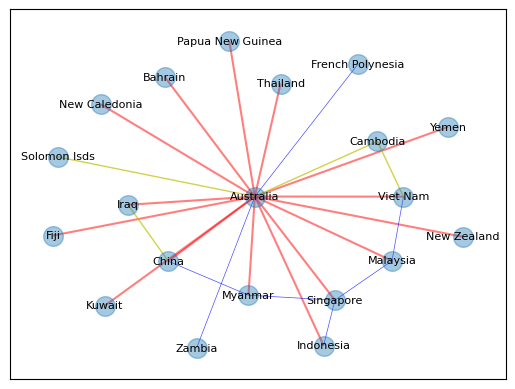

2
3
4


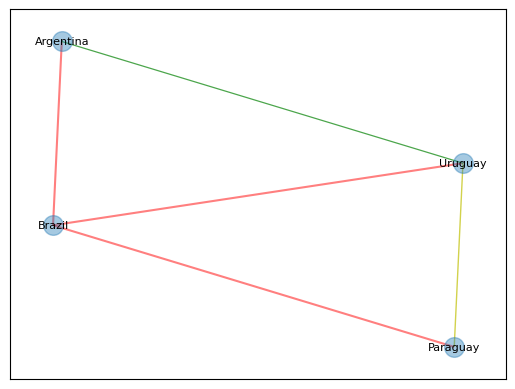

5
6
7


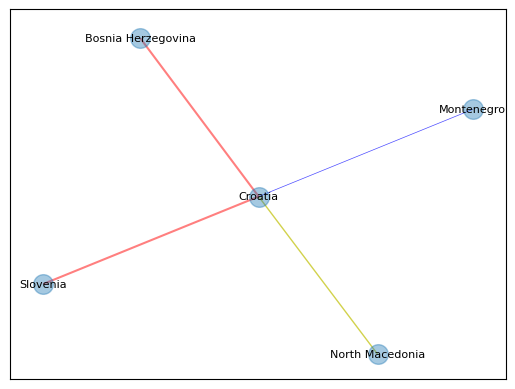

8
9


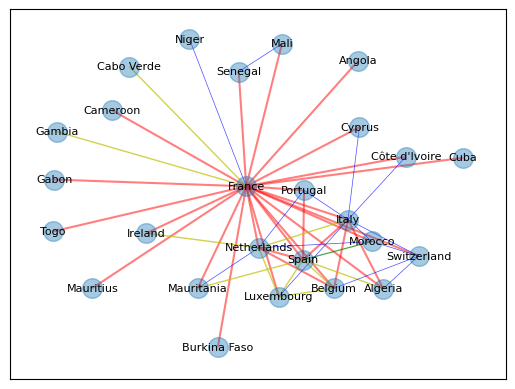

10


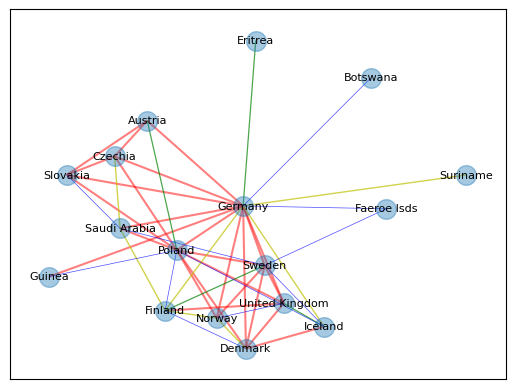

11
12


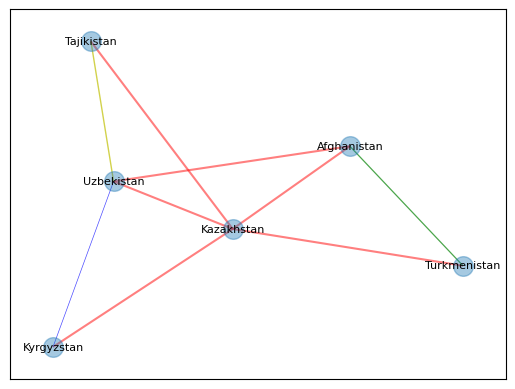

13
14


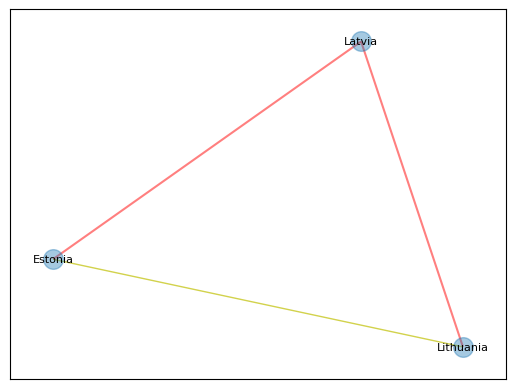

15
16
17


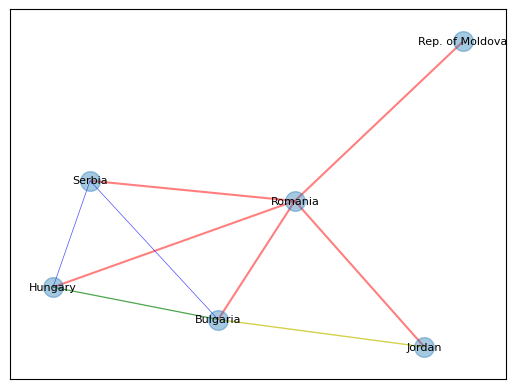

18


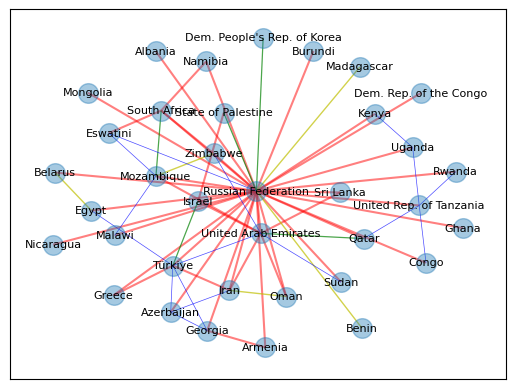

19
20
21


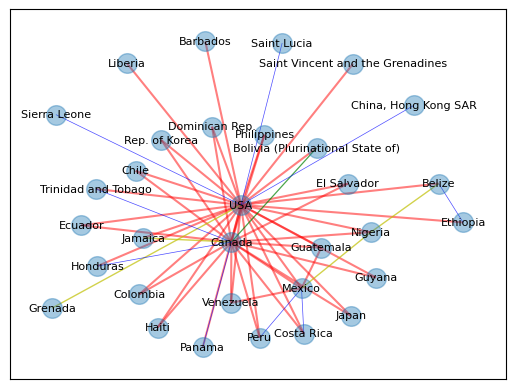

22


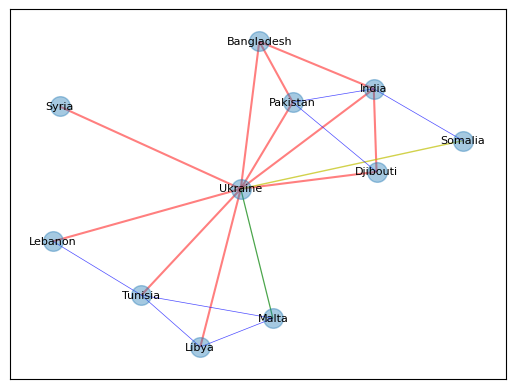

In [4]:
top10 = np.asarray(["Russian Federation", "Australia", "USA", "Canada", "Ukraine", "France", "Argentina", "Germany", "Romania", "India"])

preference = - np.ones((num_labels,))
idx = le.transform(top10.reshape(-1,1)).astype(int).flatten()
preference[idx] = 0.

from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(affinity="precomputed",max_iter=10000,preference = None,damping=0.5)
aff_map = trade_map_sparse.toarray()
aff_map = np.nan_to_num(aff_map)

clustering = model.fit_predict(aff_map)

import matplotlib.pyplot as plt
import networkx as nx

ids, counts = np.unique(clustering, return_counts = True)

avg_weight = trade_map_sparse.mean()

for i,c in enumerate(ids):
    print(c)
    G = nx.Graph()

    
    for j in range(clustering.shape[0]):
        if clustering[j] == c:
            #print(c,le.inverse_transform([j])[0])
            for k in range(clustering.shape[0]):
                if clustering[k] == c:
                    if  trade_map_sparse[j,k] > 0.:
                        #print(c,le.inverse_transform([j])[0], le.inverse_transform([k])[0], trade_map_sparse[j,k])
                        G.add_edge(le.inverse_transform([[j]])[0][0], le.inverse_transform([[k]])[0][0], weight= trade_map_sparse[j,k])
                        
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > avg_weight*2.5]
    ealarge = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > avg_weight*1.2) and (d["weight"] <= avg_weight*2.5))]
    emed = [(u, v) for (u, v, d) in G.edges(data=True) if ((d["weight"] > avg_weight*0.8) and (d["weight"] <= avg_weight*1.2))]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= avg_weight*0.8]

    if len(elarge + esmall+emed+ealarge) > 2 and len(elarge) > 0:
        layout = nx.spring_layout(G, seed=7,weight=None)
        #nx.draw(G, layout)
        nx.draw_networkx_nodes(G, layout, node_size=200,alpha=0.4)
    
        # edges
        nx.draw_networkx_edges(G, layout, edgelist=elarge, width=1.5,alpha=0.5,edge_color="r")
        nx.draw_networkx_edges(
            G, layout, edgelist=ealarge, width=1.0, alpha=0.7, edge_color="y"
        )           
        nx.draw_networkx_edges(
            G, layout, edgelist=emed, width=0.9, alpha=0.7, edge_color="g"
        )        
        nx.draw_networkx_edges(
            G, layout, edgelist=esmall, width=0.5, alpha=0.7, edge_color="b"
        )
        
        # node labels
        nx.draw_networkx_labels(G, layout, font_size=8, font_family="sans-serif")
        # edge weight labels
        #edge_labels = nx.get_edge_attributes(G, "weight")
        #nx.draw_networkx_edge_labels(G, layout, edge_labels,font_size=6)
        plt.show()    

    

In [5]:
years = np.unique(trade_export[:,0])

## Use the clusters to build dataset

In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.preprocessing import LabelEncoder

trade_clusters = []
#; un['num_states'] : nb of states, an integer (N)
#; un['production'] : tensor of size N, each element is a production value, a float number > 0
#; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
#; un['pred_export']

cluster_year = {}

for i,c in enumerate(ids):
    print("Cluster ",c)
    for year in range(1993,2023,5):
        countries = {}
        cdata = {}
        for j in range(clustering.shape[0]):
            if clustering[j] == c:
                for k in range(clustering.shape[0]):
                    if clustering[k] == c:
                        ty = trade_export[(trade_export[:,0] >= year)&(trade_export[:,0] < year + 7)&(trade_export[:,1] == j)&(trade_export[:,2] == k)]
                        tyi = trade_import[(trade_import[:,0] >= year)&(trade_import[:,0] < year + 7)&(trade_import[:,1] == j)&(trade_import[:,2] == k)]
                        if len(ty) > 0:
                            countries[j] = True
                            countries[k] = True
                            datas = np.zeros((5,2))
                            targets = np.zeros((5,))
                            too_small_flag = 0
                            for y in range(year,year + 5):
                                val = ty[ty[:,0] == y]
                                imp_val = tyi[tyi[:,0] == y]
                                if len(val) > 0:
                                    if val[0,3] < 500000:
                                        too_small_flag += 1    
                                    datas[y - year,0] = val[0,3]

                                    if len(imp_val) > 0:
                                        datas[y - year,1] = imp_val[0,3]
                                    val = ty[ty[:,0] == y + 1]
                                    if len(val) > 0:
                                        targets[y - year] = val[0,3]# - datas[y - year,0]
                                    else:
                                        if y > year:
                                            print(c,y,j,k,"got prev target")
                                            targets[y - year] = targets[y - year - 1]
                                else:
                                    too_small_flag += 1       
                            if (datas[:,0] > 0).sum() > 4 and too_small_flag < 2:
                                cdata[(j,k)] = [datas, targets]  
        if len(cdata) > 0:                     
            cluster_year[(c,year)] = [countries,cdata]

Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
Cluster  22


In [7]:
features_min, features_max = np.load("norm_constants.npy",allow_pickle=True)

#norm
for c,y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        #cluster_year[c,y][1][j,k][1][np.abs(cluster_year[c,y][1][j,k][1]) < 1] = 1
        #cluster_year[c,y][1][j,k][1] = np.sign(cluster_year[c,y][1][j,k][1])*np.log(np.abs(cluster_year[c,y][1][j,k][1])) / 22
        #cluster_year[c,y][1][j,k][1] = cluster_year[c,y][1][j,k][1] / (target_maxnn/4)
        cluster_year[c,y][1][j,k][1] = cluster_year[c,y][1][j,k][1] / (features_max[0])
        cluster_year[c,y][1][j,k][1][cluster_year[c,y][1][j,k][1] > 1.] = 1.
        cluster_year[c,y][1][j,k][1][cluster_year[c,y][1][j,k][1] < -1.] = -1.        
        cluster_year[c,y][1][j,k][0] = (cluster_year[c,y][1][j,k][0] - features_min[:2]) / (features_max[:2] - features_min[:2])
 

## Add FAO

In [8]:
fao = pd.read_csv("fao.csv",sep=";")[["Area", "Year", "Value"]].to_numpy()
fao = np.hstack([le.transform(fao[:,0].reshape(-1,1)).astype(int),fao[:,1:3]])

import copy
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA

todel = []
for c,y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        years = []
        years2 = []
        for yr in range(y, y + 5):
            fcy = fao[(fao[:,0] == j)&(fao[:,1] == yr)]
            if len(fcy) > 0 and not np.isnan(fcy[0,2]):
                years.append(fcy[0,2])
            else:
                print("zero prod:",c,y,j,k,yr)
                years.append(0.)

            fc = fao[(fao[:,0] == k).flatten()]
            if len(fc) > 0:
                fcy = fc[fc[:,1] == yr]
                if len(fcy) > 0 and not np.isnan(fcy[0,2]):
                    years2.append(fcy[0,2])
                else:
                    years2.append(0.)        
        years = np.asarray(years)  
        years2 = np.asarray(years2)  
        if years.sum() == 0:
            todel.append((c,y,j,k))    
        else: 
            #years[years == 0.] = years.mean()
            transformer = Imputer(method="forecaster", forecaster=AutoARIMA(d=0, suppress_warnings=True))
            years = transformer.fit_transform(years.reshape(1,-1)).flatten()            
            tmp =  copy.deepcopy(cluster_year[c,y][1][j,k][0])
            cluster_year[c,y][1][j,k][0] = np.hstack([ tmp, np.asarray(years - features_min[2]).reshape(-1,1) / (features_max[2] - features_min[2]),np.asarray(years2 - features_min[2]).reshape(-1,1) / (features_max[2] - features_min[2])])
         

            

## remove small or empty clusters

In [9]:
for c,y,j,k in todel:
    if (c,y) in cluster_year:
        del cluster_year[c,y][1][j,k]    
        if len(cluster_year[c,y][1]) < 3:
            del cluster_year[c,y]

## Draw export distribution

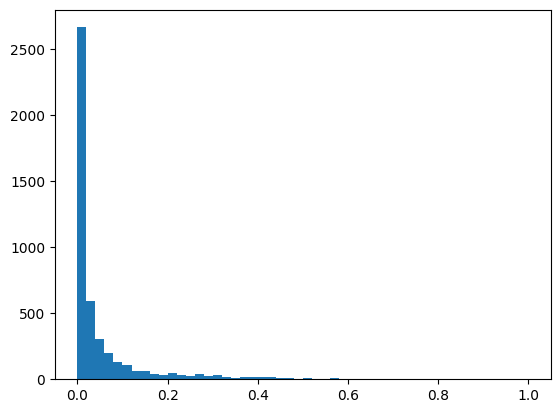

In [10]:
targs = []
for c, y in cluster_year:
    for j,k in cluster_year[c,y][1]:
        targs += [cluster_year[c,y][1][j,k][1]]

atargs = np.hstack(targs)

import matplotlib.pyplot as plt
import numpy as np


# Create the histogram
plt.hist(atargs.flatten(), bins=50)

# Show the plot
plt.show()

In [11]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy

with open('cluster_year.pkl', 'wb') as f:
    pickle.dump(cluster_year, f)

with open('name_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
